In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays # 可选，用于处理稀疏性（如果数据量很大）
using FileIO
using JLD2
using Plots
using LaTeXStrings

using DataFrames, Colors
using StatsPlots   # 提供 boxplot，基于 Plots


include("Data_Generation_Product_Design.jl")
include("Estimation_Product_Design.jl")
include("Product_Design_Models.jl")
include("Evaluation_Product_Design.jl")

calculate_profit (generic function with 1 method)

In [2]:
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/Product_Design/20250925/")
if !isdir(data_dir)
    mkpath(data_dir)
end
println("Data directory: ", data_dir)

Data directory: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/


In [3]:
d = 20 # num of product feature
p = 1 # num of customer feature
n = 100 # num of training samples
n_test = 1
m = 5 # num of products
s = 10
lambda_list = [0.0]
gamma_list = [0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]
psi_lb = -10
psi_ub = 10
phi_lb = -10
phi_ub = 10

instances = 100

Random.seed!(1)

TaskLocalRNG()

#### Data Generation

In [4]:
Input_Data = Dict()
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    # ****** Data ******
    theta_true, r_params = Generate_Wang_Qi_Max_True_Paras(d,p,s);
    X_train,Y_train,Z_train = Generate_Wang_Qi_Max_True_Data(d, p, n, m,theta_true);
    X_test,Y_test,Z_test = Generate_Wang_Qi_Max_True_Data(d, p, n_test, m,theta_true);

    Input_Data["theta_true_ins=$ins"] = theta_true
    Input_Data["r_params_ins=$ins"] = r_params
    Input_Data["X_train_ins=$ins"] = X_train
    Input_Data["Y_train_ins=$ins"] = Y_train
    Input_Data["Z_train_ins=$ins"] = Z_train
    Input_Data["X_test_ins=$ins"] = X_test
    Input_Data["Y_test_ins=$ins"] = Y_test
    Input_Data["Z_test_ins=$ins"] = Z_test
end
save(string(data_dir,"Input_Data.jld2"),Input_Data)

#### Estimation

In [5]:
Estimate_Dict = Dict()
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    X_train = Input_Data["X_train_ins=$ins"]
    Y_train = Input_Data["Y_train_ins=$ins"]
    Z_train = Input_Data["Z_train_ins=$ins"]
    for lambda in lambda_list
        alpha0_hat, alpha_hat, beta_hat, A_hat, opt_result = estimate_parameters(X_train,Y_train,Z_train,lambda, d, p, initial_theta=randn((d+1)*(p+1)) * 0.1);
        Estimate_Dict["alpha0_ins=$(ins)_lambda=$lambda"] = alpha0_hat
        Estimate_Dict["alpha_ins=$(ins)_lambda=$lambda"] = alpha_hat
        Estimate_Dict["beta_ins=$(ins)_lambda=$lambda"] = beta_hat
        Estimate_Dict["A_ins=$(ins)_lambda=$lambda"] = A_hat
        Estimate_Dict["opt_result_ins=$(ins)_lambda=$lambda"] = opt_result
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
end
save(string(data_dir,"Estimate_Dict.jld2"),Estimate_Dict)

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=6/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=7/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=8/*************


In [6]:
# 初始化 5x50 的零矩阵
C_mat = zeros(Int, 3, d)
# # 按行设置：第 i 行从第 (i-1)*10 + 1 列到第 i*10 列设为 1
# for i in 1:2
#     start_col = (i - 1) * 10 + 1
#     end_col = i * 10
#     C_mat[i, start_col:end_col] .= 1
# end
# # 显示结果
# display(C_mat)

3×20 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

#### True

In [7]:
Result_True_Dict = Dict();
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    theta_true = Input_Data["theta_true_ins=$ins"]
    r_params = Input_Data["r_params_ins=$ins"]
    X_train = Input_Data["X_train_ins=$ins"]
    Y_train = Input_Data["Y_train_ins=$ins"]
    Z_train = Input_Data["Z_train_ins=$ins"]
    X_test = Input_Data["X_test_ins=$ins"]
    Y_test = Input_Data["Y_test_ins=$ins"]
    Z_test = Input_Data["Z_test_ins=$ins"]
    r0 = r_params.r0;
    r = r_params.r;
    alp0_true = theta_true.alpha0;
    alp_true = theta_true.alpha;
    beta_true = theta_true.beta;
    A_true = theta_true.A;

    obj_True_list = zeros(n_test);
    x_True_list = zeros(n_test,d);
    time_True_list = zeros(n_test);
    profit_True_list = zeros(n_test);
    for i in 1:n_test
        z_input = Z_test[i,:];
        nu0 = alp0_true + beta_true' * z_input;
        nu = alp_true .+ A_true * z_input;
        # obj_True_list[i], x_True_list[i,:], time_True_list[i] = Product_Design_Ours_ETO(d,nu0, nu, r0, r, z_input);
        obj_True_list[i], x_True_list[i,:], time_True_list[i] = Product_Design_ETO(d,nu0, nu, r0, r, C_mat);
        profit_True_list[i] = calculate_profit(alp0_true, alp_true, beta_true, A_true, r0, r, x_True_list[i,:], z_input)
        # if i % 20 == 1
        #     println("True: i=$i, obj=$(round(obj_True_list[i], digits=4)), profit=$(round(profit_True_list[i], digits=4)),x=$(round.(x_True_list[i,:], digits=4)), time=$(round(time_True_list[i],digits=4))")
        # end
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
    Result_True_Dict["obj_ins=$ins"] = obj_True_list
    Result_True_Dict["sol_ins=$ins"] = x_True_list
    Result_True_Dict["time_ins=$ins"] = time_True_list
    Result_True_Dict["profit_ins=$ins"] = profit_True_list
end
save(string(data_dir,"Result_True.jld2"),Result_True_Dict) 

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=6/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=7/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=8/*************


#### Estimate-then-optimize

In [8]:
Result_ETO_Dict = Dict();
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    theta_true = Input_Data["theta_true_ins=$ins"]
    r_params = Input_Data["r_params_ins=$ins"]
    X_train = Input_Data["X_train_ins=$ins"]
    Y_train = Input_Data["Y_train_ins=$ins"]
    Z_train = Input_Data["Z_train_ins=$ins"]
    X_test = Input_Data["X_test_ins=$ins"]
    Y_test = Input_Data["Y_test_ins=$ins"]
    Z_test = Input_Data["Z_test_ins=$ins"]
    r0 = r_params.r0;
    r = r_params.r;
    alp0_true = theta_true.alpha0;
    alp_true = theta_true.alpha;
    beta_true = theta_true.beta;
    A_true = theta_true.A;

    lambda_len = length(lambda_list)
    for l_index in 1:lambda_len
        lambda = lambda_list[l_index]
        alpha0_hat = Estimate_Dict["alpha0_ins=$(ins)_lambda=$lambda"]
        alpha_hat = Estimate_Dict["alpha_ins=$(ins)_lambda=$lambda"]
        beta_hat = Estimate_Dict["beta_ins=$(ins)_lambda=$lambda"]
        A_hat = Estimate_Dict["A_ins=$(ins)_lambda=$lambda"]

        obj_ETO_list = zeros(n_test);
        x_ETO_list = zeros(n_test,d);
        time_ETO_list = zeros(n_test);
        profit_ETO_list = zeros(n_test);
        for i in 1:n_test
            z_input = Z_test[i,:];
            nu0 = alpha0_hat + beta_hat' * z_input;
            nu = alpha_hat .+ A_hat * z_input;
            # obj_ETO_list[i], x_ETO_list[i,:], time_ETO_list[i] = Product_Design_Ours_ETO(d,nu0, nu, r0, r, z_input);
            obj_ETO_list[i], x_ETO_list[i,:], time_ETO_list[i] = Product_Design_ETO(d,nu0, nu, r0, r, C_mat);
            profit_ETO_list[i] = calculate_profit(alp0_true, alp_true, beta_true, A_true, r0, r, x_ETO_list[i,:], z_input)
            # if i % 20 == 1
            #     println("ETO: lambda=$lambda,i=$i, 
            #     obj=$(round(obj_ETO_list[i], digits=4)), profit=$(round(profit_ETO_list[i], digits=4)),
            #     x=$(round.(x_ETO_list[i,:], digits=4)), time=$(round(time_ETO_list[i],digits=4))")
            # end
        end

        Result_ETO_Dict["obj_ins=$(ins)_lambda=$lambda"] = obj_ETO_list
        Result_ETO_Dict["sol_ins=$(ins)_lambda=$lambda"] = x_ETO_list
        Result_ETO_Dict["time_ins=$(ins)_lambda=$lambda"] = time_ETO_list
        Result_ETO_Dict["profit_ins=$(ins)_lambda=$lambda"] = profit_ETO_list
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
end
save(string(data_dir,"Result_ETO.jld2"),Result_ETO_Dict) 

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=6/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=7/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=8/*************


#### Robust

In [9]:
function calculate_phi_bounds(r0, r, if_lb)
    model = Model(Mosek.Optimizer)
    set_attribute(model, "QUIET", true)
    # 定义变量
    @variable(model, x[1:d], Bin)

    @constraint(model, sum(x) >= 1)
    if if_lb
        @objective(model, Min,r0 * a1 + r' * x)
    else
        @objective(model, Max,r0 * a1 + r' * x)
    end
    optimize!(model)
    status = JuMP.termination_status(model)
    if status == MOI.OPTIMAL
        obj_val = objective_value(model)
        x_val = value.(x)
        solve_time = JuMP.solve_time(model)
    else
        obj_val = NaN
        x_val = ones(d) .* NaN
        solve_time = NaN
    end
    return obj_val, x_val, solve_time    
end

calculate_phi_bounds (generic function with 1 method)

In [10]:
function calculate_psi_bounds(alpha0, alpha, beta, A, z_input)
    model = Model(Mosek.Optimizer)
    set_attribute(model, "QUIET", true)
    # 定义变量
    @variable(model, x[1:d], Bin)

    @constraint(model, sum(x) >= 1)
    if if_lb
        @objective(model, Min,r0 * a1 + r' * x)
    else
        @objective(model, Max,r0 * a1 + r' * x)
    end
    optimize!(model)
    status = JuMP.termination_status(model)
    if status == MOI.OPTIMAL
        obj_val = objective_value(model)
        x_val = value.(x)
        solve_time = JuMP.solve_time(model)
    else
        obj_val = NaN
        x_val = ones(d) .* NaN
        solve_time = NaN
    end
    return obj_val, x_val, solve_time    
end

calculate_psi_bounds (generic function with 1 method)

In [11]:
function obtain_all_bounds(r0, r)
    obj_lb,x_lb,time_lb = calculate_phi_bounds(r0, r, true)
    obj_ub,x_ub,time_lb = calculate_phi_bounds(r0, r, false)
    phi_lb = obj_lb - obj_ub
end

obtain_all_bounds (generic function with 1 method)

In [12]:
Result_RO_Dict = Dict();
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")

    theta_true = Input_Data["theta_true_ins=$ins"]
    r_params = Input_Data["r_params_ins=$ins"]
    X_train = Input_Data["X_train_ins=$ins"]
    Y_train = Input_Data["Y_train_ins=$ins"]
    Z_train = Input_Data["Z_train_ins=$ins"]
    X_test = Input_Data["X_test_ins=$ins"]
    Y_test = Input_Data["Y_test_ins=$ins"]
    Z_test = Input_Data["Z_test_ins=$ins"]
    r0 = r_params.r0;
    r = r_params.r;
    alp0_true = theta_true.alpha0;
    alp_true = theta_true.alpha;
    beta_true = theta_true.beta;
    A_true = theta_true.A;

    lambda_len = length(lambda_list)
    gamma_len = length(gamma_list)

    for l_index in 1:lambda_len
        lambda = lambda_list[l_index]
        alpha0_hat = Estimate_Dict["alpha0_ins=$(ins)_lambda=$lambda"]
        alpha_hat = Estimate_Dict["alpha_ins=$(ins)_lambda=$lambda"]
        beta_hat = Estimate_Dict["beta_ins=$(ins)_lambda=$lambda"]
        A_hat = Estimate_Dict["A_ins=$(ins)_lambda=$lambda"]

        for g_index in 1:gamma_len
            gamma = gamma_list[g_index]

            obj_RO_list = zeros(n_test);
            x_RO_list = zeros(n_test,d);
            time_RO_list = zeros(n_test);
            profit_RO_list = zeros(n_test);
            for i in 1:n_test
                z_input = Z_test[i,:];
                # obj_RO_list[i], x_RO_list[i,:], time_RO_list[i] = Robust_Product_Design(2, d, p, gamma, psi_lb, psi_ub, phi_lb, phi_ub, alpha0_hat, alpha_hat, beta_hat, A_hat, r0, r, z_input,C_mat);
                
                nu0 = alpha0_hat + beta_hat' * z_input;
                nu = alpha_hat .+ A_hat * z_input;
                obj_RO_list[i], x_RO_list[i,:], time_RO_list[i] = Robust_Product_Design_Condense_Parameters(2, d, gamma, psi_lb, psi_ub, phi_lb, phi_ub, nu0, nu, r0, r)
                
                profit_RO_list[i] = calculate_profit(alp0_true, alp_true, beta_true, A_true, r0, r, x_RO_list[i,:], z_input)
                # if i % 20 == 1
                #     println("RO: lambda=$lambda,gamma=$gamma, i=$i, obj=$(round(obj_RO_list[i], digits=4)), profit=$(round(profit_RO_list[i], digits=4)),x=$(round.(x_RO_list[i,:], digits=4)), time=$(round(time_RO_list[i],digits=4))")
                # end
            end
            Result_RO_Dict["obj_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = obj_RO_list
            Result_RO_Dict["sol_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = x_RO_list
            Result_RO_Dict["time_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = time_RO_list
            Result_RO_Dict["profit_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = profit_RO_list
        end
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
end
save(string(data_dir,"Result_RO.jld2"),Result_RO_Dict) 

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=6/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=7/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/instance=8/*************


#### Results

In [13]:
Result_True_Dict = load(string(data_dir,"Result_True.jld2"));
Result_ETO_Dict = load(string(data_dir,"Result_ETO.jld2"));
Result_RO_Dict = load(string(data_dir,"Result_RO.jld2"));

In [14]:
profit_True_avg = zeros(instances);
profit_ETO_avg = zeros(instances, length(lambda_list));
profit_RO_avg = zeros(instances, length(lambda_list), length(gamma_list));
for ins in 1:instances
    profit_True_avg[ins] = mean(Result_True_Dict["profit_ins=$ins"])
    for l_index in 1:length(lambda_list)
        lambda = lambda_list[l_index]
        profit_ETO_avg[ins,l_index] = mean(Result_ETO_Dict["profit_ins=$(ins)_lambda=$lambda"])
        for g_index in 1:length(gamma_list)
            gamma = gamma_list[g_index]
            profit_RO_avg[ins,l_index,g_index] = mean(Result_RO_Dict["profit_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"])
            # println("ins=$ins, lambda=$lambda, gamma=$gamma, profit_True_avg=$(round(profit_True_avg,digits=4)), profit_ETO_avg=$(round(profit_ETO_avg,digits=4)), profit_RO_avg=$(round(profit_RO_avg,digits=4))")
        end
    end
end

##### Line plot 

In [15]:
l_index = 1
RO_ETO_Ratio_Mean = zeros(length(gamma_list))
RO_ETO_Ratio_Std = zeros(length(gamma_list))
for g_index in 1:length(gamma_list)
    gamma = gamma_list[g_index]
    RO_ETO_Ratio_Mean[g_index] = mean(profit_RO_avg[:,l_index,g_index])/mean(profit_ETO_avg[:,l_index])
    RO_ETO_Ratio_Std[g_index] = std(profit_RO_avg[:,l_index,g_index])/std(profit_ETO_avg[:,l_index])
    println("gamma=$gamma,Mean =",RO_ETO_Ratio_Mean[g_index],", Std =",RO_ETO_Ratio_Std[g_index])
end

gamma=0.0,Mean =1.0000000614626676, Std =0.9999999033728199
gamma=0.05,Mean =1.0057803430898333, Std =0.9822907974761574
gamma=0.1,Mean =1.0115352153317927, Std =0.9875536602959698
gamma=0.2,Mean =1.0114995477779103, Std =0.9751079783379758
gamma=0.3,Mean =1.0132649294650844, Std =0.9850083773373489
gamma=0.4,Mean =1.0019405056094948, Std =0.9930727597456971
gamma=0.5,Mean =0.9990044794935092, Std =0.9783915279832713
gamma=0.6,Mean =1.0003699035085263, Std =0.9669013612329261
gamma=0.8,Mean =0.9851157478730767, Std =0.9594054977990975
gamma=1.0,Mean =0.9661161141684563, Std =0.9747360914822201


In [21]:
end_index = 10
plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
hline!([1.0], linestyle=:dash, color=:red, label="")
savefig(string(data_dir, "RPD_vs_ETOPD.pdf"))

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Design/20250925/RPD_vs_ETOPD.pdf"

##### Boxplot

In [17]:
Profit_ETO_All_Ins = profit_ETO_avg[:,1];
Profit_RO_All_Ins = Dict();
for g_index in 1:length(gamma_list)
    gamma=gamma_list[g_index]
    Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO_avg[:,1,g_index]
end

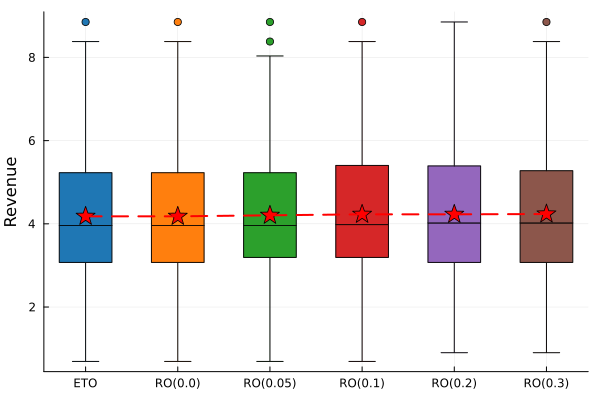

In [18]:
gamma_chosen = gamma_list[1:5]
data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# --- 1) 展开成长表 ---
df = DataFrame(
    value = vcat(data...),
    group = repeat(labels, inner = length(data[1]))
)

mycolors = palette(:tab10)[1:length(labels)]   # tab10 最多10个颜色

# --- 3) 绘制箱线图 ---
@df df boxplot(:group, :value;
    group = :group,
    palette = mycolors,
    legend = false,
    ylabel = "Revenue",
    # title = "Revenue Distribution"
)

# --- 4) 计算均值 ---
means = combine(groupby(df, :group), :value => mean => :mean_val)

for i in 1:length(labels)
    scatter!([labels[i]], [means.mean_val[i]];
        color = :red,
        marker = (:star, 10),
        label = "")
end

# # --- 6) 绘制均值连线（这里必须把类别转为数值 1:N） ---
plot!(labels, means.mean_val;
    seriestype = :line,
    color = :red,
    lw = 2,
    ls = :dash,
    label = "Mean trend"
)